In [7]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.gridspec import GridSpec
from doetools import TensionBucklingDOE

from sympy import symbols, solve, init_printing, Eq, lambdify

%matplotlib inline
init_printing()

## $\lambda-\mu$ plot of $t_c$ and mode number

In [2]:
mu, lam = symbols('mu lambda', real=True)
n = symbols('n', real=True)

tcn = 1/(n**2 - 1) * (mu*n**2*(n**2-1)**2/(1 + mu*n**2) + lam)

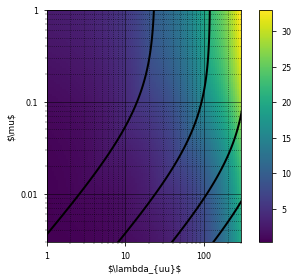

In [4]:
# Draw colormap for tc
n_l, n_mu = (100, 100)
ll, mm = np.meshgrid(np.logspace(0., np.log10(300), n_l), np.logspace(0, np.log10(0.003), n_mu))

# Convert t_cn to a callable function which operates element-wise on inputs
tcn_fxn = np.vectorize(lambdify((lam, mu, n), tcn))

tc = np.amin(np.concatenate((tcn_fxn(ll, mm, 2).reshape((n_l, n_mu, 1)),
                             tcn_fxn(ll, mm, 3).reshape((n_l, n_mu, 1)),
                             tcn_fxn(ll, mm, 4).reshape((n_l, n_mu, 1))), axis=2), axis=2)


with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(ncols=2, figsize=(4.25, 4.0), gridspec_kw={'width_ratios': [15, 1]})

    tc_c = ax[0].pcolormesh(ll, mm, tc, cmap='viridis')

    # plt.colorbar(tc_c, fraction=0.046, pad=0.04)
    plt.colorbar(tc_c, cax=ax[1])

    ax[0].set_yscale('log')
    ax[0].set_xscale('log')


    # Superimpose boundaries between mode regions, and add grid
    mmu = np.logspace(-3, 0, 100)

    for m in range(5):
        lam_nm = lambdify(mu, solve(Eq(tcn.subs(n, m+2) - tcn.subs(n, m+3)), lam)[0])
        ax[0].plot(lam_nm(mmu), mmu, 'k', linewidth=2)

    ax[0].grid(b=True, which='major', color='k', linestyle='-', alpha=0.6)
    ax[0].grid(b=True, which='minor', color='k', linestyle=':', alpha=0.6)

    ax[0].set_xlim([1., 300.])
    ax[0].set_ylim([.003, 1.0])

    ax[0].set_xticks([1., 10., 100.])
    ax[0].set_xticklabels(['1', '10', '100'])

    ax[0].set_yticks([0.01, 0.1, 1.0])
    ax[0].set_yticklabels(['0.01', '0.1', '1'])

    ax[0].set_xlabel('\$\lambda_{uu}\$')
    ax[0].set_ylabel('\$\mu\$')

    plt.tight_layout()
    plt.savefig('../figs/buckling_tension/_python_tc_l-mu_map.pdf')

## ABAQUS numerical experiments

In [ ]:
# Hold mu fixed, vary lambda

lambda_dir = '../data/doe/doe_Tc_lambda'

if False:

    up = 0.01e-3
    doe = TensionBucklingDOE(out_dir=lambda_dir,
                             opts={'spk_paired': False,
                                   'spk_eltype': 'beam',
                                   'rim_perturb': [0., up, up, up, up]})

    mu = 26./69.
    for lam in 5.*np.logspace(0, 2, 16):

        wheel = create_wheel_from_lm(l=lam, mu=mu)
        
        Tc, nc = bl.calc_buckling_tension(wheel)
        
        jobname = 'Tc_lambda{:.1f}'.format(lam)

        doe.add_experiment(wheel, opts={'jobname': jobname,
                                        'lambda': lam,
                                        'mu': mu})

    print('\nCreated {0:d} simulations'.format(len(doe.db)))

    doe.write_input_files(N_batches=2)
    doe.to_csv()

In [ ]:
# Hold lambda fixed, vary mu

mu_dir = '../data/doe/doe_Tc_mu'

if False:
    
    up = 0.01e-3
    doe = TensionBucklingDOE(out_dir=mu_dir,
                             opts={'spk_paired': False,
                                   'spk_eltype': 'beam',
                                   'rim_perturb': [0., up, up, up, up]})

    lam = 10.0
    for mu in 1.*np.logspace(-2, 0, 16):

        wheel = create_wheel_from_lm(l=lam, mu=mu)
        
        jobname = 'Tc_mu{:.3f}'.format(mu)

        doe.add_experiment(wheel, opts={'jobname': jobname,
                                        'lambda': lam,
                                        'mu': mu})

    print('\nCreated {0:d} simulations'.format(len(doe.db)))

    doe.write_input_files(N_batches=1)
    doe.to_csv()

In [31]:
# Load DOE database
doe_l = TensionBucklingDOE(out_dir='../data/doe/doe_Tc_lambda', db_file='../data/doe/doe_Tc_lambda/_doe_db.csv')
doe_l.extract_results()

# Load DOE database
doe_m = TensionBucklingDOE(out_dir='../data/doe/doe_Tc_mu', db_file='../data/doe/doe_Tc_mu/_doe_db.csv')
doe_m.extract_results()

# Calculate normalized tension
def calc_t(doe, r):
    w = doe.wheel_from_row(r)
    
    Tbar = len(w.spokes)*w.spokes[0].n[1]*w.rim.radius**2 /\
        (2*np.pi*w.rim.young_mod*w.rim.I22)
    
    return Tbar
    
doe_l.db['tc'] = doe_l.db['Tc_nonlin']*doe_l.db.apply(lambda x: calc_t(doe_l, x), axis=1)
doe_m.db['tc'] = doe_m.db['Tc_nonlin']*doe_m.db.apply(lambda x: calc_t(doe_m, x), axis=1)

..................Error on Tc_mu0.014: expected non-empty vector for x
..............

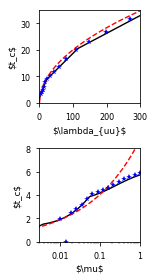

In [30]:
ll = np.linspace(0., 300, 100)
tc_l = np.amin(np.concatenate((tcn_fxn(ll, 26./69., 2).reshape((1, len(ll))),
                               tcn_fxn(ll, 26./69., 3).reshape((1, len(ll))),
                               tcn_fxn(ll, 26./69., 4).reshape((1, len(ll))),
                               tcn_fxn(ll, 26./69., 5).reshape((1, len(ll)))), axis=0), axis=0)

with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(nrows=2, figsize=(2.25, 4.0))

    ax[0].plot(ll, tc_l, 'k')
    ax[0].plot(ll, 2*ll**0.5, 'r--')
    ax[0].plot(doe_l.db['lambda'], doe_l.db['tc'], 'b*')

    ax[0].set_xlim([0., 300])
    ax[0].set_ylim([0., 35])
    ax[0].set_xticks([0, 100, 200, 300])
    ax[0].set_yticks([0, 10, 20, 30])

    ax[0].set_xlabel('\$\lambda_{uu}\$')
    ax[0].set_ylabel('\$t_c\$')

    mm = np.logspace(-3, 0., 100)
    tc_m = np.amin(np.concatenate((tcn_fxn(10., mm, 2).reshape((1, len(mm))),
                                   tcn_fxn(10., mm, 3).reshape((1, len(mm))),
                                   tcn_fxn(10., mm, 4).reshape((1, len(mm)))), axis=0), axis=0)

    ax[1].semilogx(mm, tc_m, 'k')
    ax[1].semilogx(mm, (1./np.power(2, 2./3) + np.power(2, 1./3)) * np.power(10**2.*mm, 1./3), 'r--')
    ax[1].semilogx(doe_m.db['mu'], doe_m.db['tc'], 'b*')

    ax[1].set_xlim([0.003, 1.])
    ax[1].set_ylim([0., 7.])

    ax[1].set_xticks([0.01, 0.1, 1])
    ax[1].set_xticklabels(['0.01', '0.1', '1'])
    ax[1].set_yticks([0, 2, 4, 6, 8])

    ax[1].set_xlabel('\$\mu\$')
    ax[1].set_ylabel('\$t_c\$')

    plt.tight_layout()
    plt.savefig('../figs/buckling_tension/_python_tc_l-mu_subplots.pdf')